In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, zipfile, random, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from collections import Counter

In [3]:
# SMART EXTRACTION + FOLDER DETECTION FIX

import zipfile, shutil, os
from pathlib import Path

# Define paths
DATA_ROOT = Path("./data_extracted_fixed")
TRAIN_ZIP = "/content/train-20251106T105502Z-1-001.zip"
VALID_ZIP = "/content/valid-20251106T105300Z-1-001.zip"
TEST_ZIP  = "/content/test-20251106T105635Z-1-001.zip"

# Clean old extraction if exists
if DATA_ROOT.exists():
    shutil.rmtree(DATA_ROOT)
DATA_ROOT.mkdir(parents=True, exist_ok=True)

def smart_extract(zip_path, target_dir):
    """Extract zip and automatically detect the actual 'train/valid/test' folder level."""
    print(f"Extracting {zip_path} ...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(target_dir)
    print(f"Extracted to {target_dir}")

    # Find the real dataset folder (contains class subfolders)
    # e.g., /data/train/train/...  or /data/train/...
    candidates = list(Path(target_dir).rglob("train"))
    if not candidates:
        candidates = list(Path(target_dir).rglob("Train"))
    if candidates:
        print(f"Found train folder candidate: {candidates[0]}")
    return target_dir

# Extract all datasets
smart_extract(TRAIN_ZIP, DATA_ROOT / "train")
smart_extract(VALID_ZIP, DATA_ROOT / "valid")
smart_extract(TEST_ZIP,  DATA_ROOT / "test")

# Detect the deepest actual directories that contain class folders
def find_actual_dataset_dir(base_dir):
    base_dir = Path(base_dir)
    subdirs = [p for p in base_dir.rglob("*") if p.is_dir() and any(f.suffix.lower() in ['.jpg', '.jpeg', '.png'] for f in p.glob("*"))]
    if subdirs:
        # Return parent folder containing class folders
        parents = {p.parent for p in subdirs}
        best = min(parents, key=lambda p: len(p.parts))
        print(f"✅ Found valid dataset directory: {best}")
        return best
    else:
        print(f"⚠️ No images found under {base_dir}, check your zip structure.")
        return base_dir

TRAIN_DIR = find_actual_dataset_dir(DATA_ROOT / "train")
VALID_DIR = find_actual_dataset_dir(DATA_ROOT / "valid")
TEST_DIR  = find_actual_dataset_dir(DATA_ROOT / "test")

print(f"\nFinal dataset directories:")
print(f"Train dir: {TRAIN_DIR}")
print(f"Valid dir: {VALID_DIR}")
print(f"Test dir:  {TEST_DIR}")

# Quick verification
for root, dirs, files in os.walk(TRAIN_DIR):
    print(f"\nSample structure check:\n{root} -> {len(dirs)} class folders")
    print("Classes:", dirs)
    break

Extracting /content/train-20251106T105502Z-1-001.zip ...
Extracted to data_extracted_fixed/train
Found train folder candidate: data_extracted_fixed/train/train
Extracting /content/valid-20251106T105300Z-1-001.zip ...
Extracted to data_extracted_fixed/valid
Extracting /content/test-20251106T105635Z-1-001.zip ...
Extracted to data_extracted_fixed/test
✅ Found valid dataset directory: data_extracted_fixed/train/train
✅ Found valid dataset directory: data_extracted_fixed/valid/valid
✅ Found valid dataset directory: data_extracted_fixed/test/test

Final dataset directories:
Train dir: data_extracted_fixed/train/train
Valid dir: data_extracted_fixed/valid/valid
Test dir:  data_extracted_fixed/test/test

Sample structure check:
data_extracted_fixed/train/train -> 4 class folders
Classes: ['no_tumor', 'meningioma', 'glioma', 'pituitary']


In [4]:
# 1) CONFIG

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_ROOT = Path("data_extracted_fixed")   # already extracted (from your previous step)
TRAIN_DIR = DATA_ROOT / "train" / "train"
VALID_DIR = DATA_ROOT / "valid" / "valid"
TEST_DIR  = DATA_ROOT / "test" / "test"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
OUTPUT_DIR = Path("models_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

In [5]:
# 2️) DATA PREPROCESSING (Fixed for RGB inputs)

print("✅ Preparing datasets...")

def create_dataset(directory, img_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        batch_size=batch_size,
        image_size=img_size,
        shuffle=shuffle,
        seed=SEED,
        color_mode="rgb"   # 👈 Force 3-channel RGB to avoid grayscale mismatch
    )
    return ds

train_ds = create_dataset(TRAIN_DIR)
val_ds   = create_dataset(VALID_DIR, shuffle=False)
test_ds  = create_dataset(TEST_DIR, shuffle=False)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# ✅ Sanity check: verify image shape
for images, labels in train_ds.take(1):
    print(f"Sample image batch shape: {images.shape}")
    print(f"Sample label batch shape: {labels.shape}")

# Normalize pixel values to [0–1]
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetch for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

✅ Preparing datasets...
Found 1695 files belonging to 4 classes.
Found 502 files belonging to 4 classes.
Found 246 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Sample image batch shape: (32, 224, 224, 3)
Sample label batch shape: (32,)


In [6]:
# 3️) DATA AUGMENTATION

print("✅ Setting up augmentation...")
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")

✅ Setting up augmentation...


In [7]:
# 4️) MODEL BUILDING (Fixed & Verified)

print("✅ Building models...")

# ---- Custom CNN ----
def build_custom_cnn(input_shape=(224,224,3), num_classes=4):
    model = models.Sequential([
        data_augmentation,
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

custom_cnn = build_custom_cnn((224,224,3), num_classes)
custom_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
custom_cnn.summary()

# ---- Transfer Learning Models ----
def build_transfer_model(base_model, num_classes=4):
    base_model.trainable = False
    inputs = layers.Input(shape=(224,224,3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

transfer_models = {
    "ResNet50": build_transfer_model(applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
    "MobileNetV2": build_transfer_model(applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
    "InceptionV3": build_transfer_model(applications.InceptionV3(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
}

✅ Building models...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


✅ Training models...

Training CustomCNN ...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4127 - loss: 1.5351

53/53 ━━━━━━━━━━━━━━━━━━━━ 385s 7s/step - accuracy: 0.4142 - loss: 1.5315 - val_accuracy: 0.3207 - val_loss: 1.3650
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 366s 7s/step - accuracy: 0.5887 - loss: 1.1634 - val_accuracy: 0.3207 - val_loss: 1.4348
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 366s 7s/step - accuracy: 0.6159 - loss: 1.0379 - val_accuracy: 0.3207 - val_loss: 1.5932
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 399s 7s/step - accuracy: 0.6466 - loss: 1.0346 - val_accuracy: 0.3307 - val_loss: 1.6976
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 369s 7s/step - accuracy: 0.6351 - loss: 1.0080 - val_accuracy: 0.4024 - val_loss: 1.7937


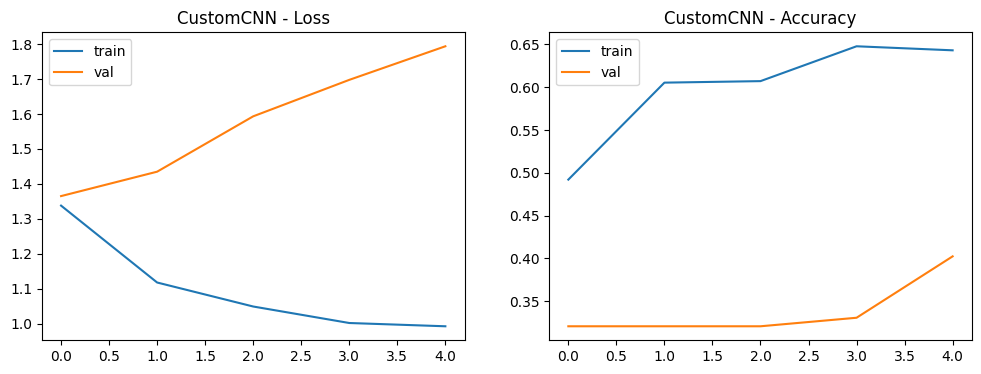


Training ResNet50 ...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2086 - loss: 2.0101

53/53 ━━━━━━━━━━━━━━━━━━━━ 468s 9s/step - accuracy: 0.2088 - loss: 2.0074 - val_accuracy: 0.3207 - val_loss: 1.6377
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2789 - loss: 1.5943

53/53 ━━━━━━━━━━━━━━━━━━━━ 447s 8s/step - accuracy: 0.2789 - loss: 1.5937 - val_accuracy: 0.3108 - val_loss: 1.4279
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2520 - loss: 1.5030

53/53 ━━━━━━━━━━━━━━━━━━━━ 442s 8s/step - accuracy: 0.2522 - loss: 1.5026 - val_accuracy: 0.3227 - val_loss: 1.3766
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2644 - loss: 1.4694

53/53 ━━━━━━━━━━━━━━━━━━━━ 434s 8s/step - accuracy: 0.2643 - loss: 1.4695 - val_accuracy: 0.3287 - val_loss: 1.3600
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2383 - loss: 1.4804

53/53 ━━━━━━━━━━━━━━━━━━━━ 451s 9s/step - accuracy: 0.2389 - loss: 1.4800 - val_accuracy: 0.3367 - val_loss: 1.3499
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2956 - loss: 1.4357

53/53 ━━━━━━━━━━━━━━━━━━━━ 502s 9s/step - accuracy: 0.2957 - loss: 1.4356 - val_accuracy: 0.3406 - val_loss: 1.3355
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3092 - loss: 1.3995

53/53 ━━━━━━━━━━━━━━━━━━━━ 492s 8s/step - accuracy: 0.3090 - loss: 1.3999 - val_accuracy: 0.3506 - val_loss: 1.3241
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3100 - loss: 1.4249

53/53 ━━━━━━━━━━━━━━━━━━━━ 442s 8s/step - accuracy: 0.3101 - loss: 1.4247 - val_accuracy: 0.3665 - val_loss: 1.3128
Epoch 9/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3053 - loss: 1.3997

53/53 ━━━━━━━━━━━━━━━━━━━━ 437s 8s/step - accuracy: 0.3053 - loss: 1.3996 - val_accuracy: 0.3865 - val_loss: 1.3045
Epoch 10/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3395 - loss: 1.3819

53/53 ━━━━━━━━━━━━━━━━━━━━ 499s 9s/step - accuracy: 0.3394 - loss: 1.3818 - val_accuracy: 0.3845 - val_loss: 1.2979
Epoch 11/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3299 - loss: 1.3755

53/53 ━━━━━━━━━━━━━━━━━━━━ 438s 8s/step - accuracy: 0.3300 - loss: 1.3754 - val_accuracy: 0.3984 - val_loss: 1.2853
Epoch 12/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3509 - loss: 1.3581

53/53 ━━━━━━━━━━━━━━━━━━━━ 441s 8s/step - accuracy: 0.3509 - loss: 1.3580 - val_accuracy: 0.4124 - val_loss: 1.2765
Epoch 13/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3388 - loss: 1.3556

53/53 ━━━━━━━━━━━━━━━━━━━━ 438s 8s/step - accuracy: 0.3386 - loss: 1.3557 - val_accuracy: 0.4163 - val_loss: 1.2683
Epoch 14/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3691 - loss: 1.3432

53/53 ━━━━━━━━━━━━━━━━━━━━ 433s 8s/step - accuracy: 0.3690 - loss: 1.3432 - val_accuracy: 0.4203 - val_loss: 1.2608
Epoch 15/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3742 - loss: 1.3265

53/53 ━━━━━━━━━━━━━━━━━━━━ 445s 8s/step - accuracy: 0.3741 - loss: 1.3264 - val_accuracy: 0.4183 - val_loss: 1.2510


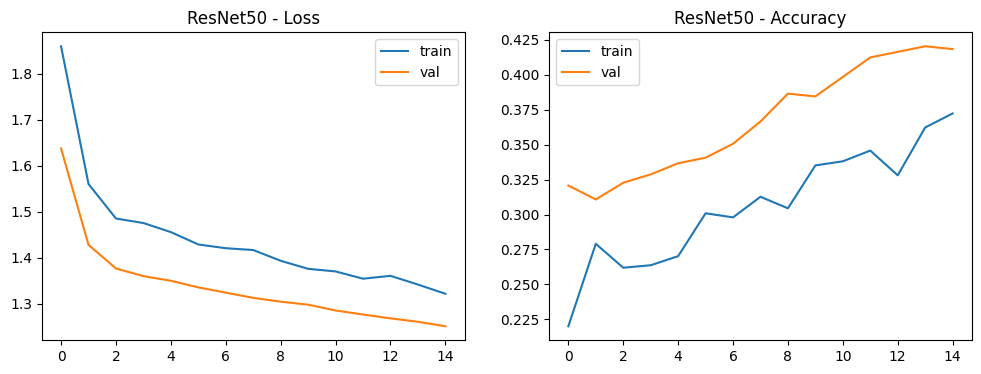


Training MobileNetV2 ...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2182 - loss: 1.7714

53/53 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.2191 - loss: 1.7687 - val_accuracy: 0.4263 - val_loss: 1.3273
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3942 - loss: 1.3460

53/53 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.3945 - loss: 1.3453 - val_accuracy: 0.5000 - val_loss: 1.1918
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4787 - loss: 1.2150

53/53 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.4792 - loss: 1.2140 - val_accuracy: 0.5538 - val_loss: 1.0896
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5435 - loss: 1.0691

53/53 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5439 - loss: 1.0687 - val_accuracy: 0.5697 - val_loss: 1.0184
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5951 - loss: 1.0048

53/53 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.5954 - loss: 1.0041 - val_accuracy: 0.6235 - val_loss: 0.9575
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6401 - loss: 0.9064

53/53 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.6403 - loss: 0.9061 - val_accuracy: 0.6454 - val_loss: 0.9173
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6546 - loss: 0.8572

53/53 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.6549 - loss: 0.8567 - val_accuracy: 0.6574 - val_loss: 0.8732
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6580 - loss: 0.8310

53/53 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.6583 - loss: 0.8308 - val_accuracy: 0.6673 - val_loss: 0.8334
Epoch 9/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7079 - loss: 0.7712

53/53 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.7078 - loss: 0.7713 - val_accuracy: 0.6693 - val_loss: 0.8195
Epoch 10/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6884 - loss: 0.7634

53/53 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.6889 - loss: 0.7629 - val_accuracy: 0.6773 - val_loss: 0.7905
Epoch 11/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7536 - loss: 0.6617

53/53 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.7530 - loss: 0.6624 - val_accuracy: 0.6892 - val_loss: 0.7703
Epoch 12/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7488 - loss: 0.6840

53/53 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.7486 - loss: 0.6842 - val_accuracy: 0.6992 - val_loss: 0.7542
Epoch 13/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7402 - loss: 0.6725

53/53 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.7402 - loss: 0.6725 - val_accuracy: 0.7171 - val_loss: 0.7432
Epoch 14/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7192 - loss: 0.7002

53/53 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7195 - loss: 0.6995 - val_accuracy: 0.7231 - val_loss: 0.7281
Epoch 15/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7471 - loss: 0.6491

53/53 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.7474 - loss: 0.6486 - val_accuracy: 0.7271 - val_loss: 0.7165


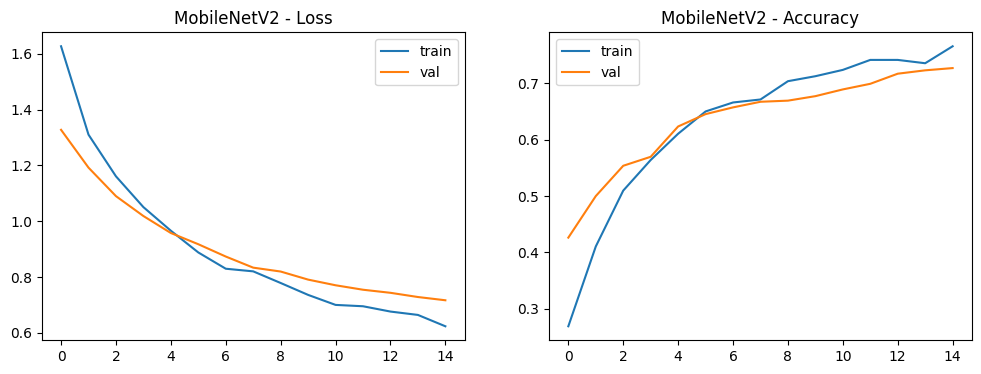


Training InceptionV3 ...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2552 - loss: 1.8078

53/53 ━━━━━━━━━━━━━━━━━━━━ 324s 6s/step - accuracy: 0.2558 - loss: 1.8045 - val_accuracy: 0.4781 - val_loss: 1.2597
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3693 - loss: 1.4063

53/53 ━━━━━━━━━━━━━━━━━━━━ 311s 6s/step - accuracy: 0.3705 - loss: 1.4048 - val_accuracy: 0.5518 - val_loss: 1.0989
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4736 - loss: 1.2169

53/53 ━━━━━━━━━━━━━━━━━━━━ 320s 6s/step - accuracy: 0.4742 - loss: 1.2159 - val_accuracy: 0.6036 - val_loss: 1.0166
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5502 - loss: 1.0842

53/53 ━━━━━━━━━━━━━━━━━━━━ 320s 6s/step - accuracy: 0.5502 - loss: 1.0838 - val_accuracy: 0.6315 - val_loss: 0.9524
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5773 - loss: 1.0002

53/53 ━━━━━━━━━━━━━━━━━━━━ 312s 6s/step - accuracy: 0.5776 - loss: 0.9997 - val_accuracy: 0.6514 - val_loss: 0.8881
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6186 - loss: 0.9308

53/53 ━━━━━━━━━━━━━━━━━━━━ 307s 6s/step - accuracy: 0.6188 - loss: 0.9306 - val_accuracy: 0.6633 - val_loss: 0.8617
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6594 - loss: 0.8472

53/53 ━━━━━━━━━━━━━━━━━━━━ 326s 6s/step - accuracy: 0.6593 - loss: 0.8475 - val_accuracy: 0.6713 - val_loss: 0.8501
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6857 - loss: 0.8076

53/53 ━━━━━━━━━━━━━━━━━━━━ 314s 6s/step - accuracy: 0.6857 - loss: 0.8078 - val_accuracy: 0.6753 - val_loss: 0.8496
Epoch 9/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6832 - loss: 0.7964

53/53 ━━━━━━━━━━━━━━━━━━━━ 339s 6s/step - accuracy: 0.6832 - loss: 0.7965 - val_accuracy: 0.7032 - val_loss: 0.7938
Epoch 10/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6867 - loss: 0.7775

53/53 ━━━━━━━━━━━━━━━━━━━━ 312s 6s/step - accuracy: 0.6869 - loss: 0.7774 - val_accuracy: 0.7231 - val_loss: 0.7638
Epoch 11/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 335s 6s/step - accuracy: 0.6950 - loss: 0.7689 - val_accuracy: 0.7052 - val_loss: 0.7812
Epoch 12/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7030 - loss: 0.7461

53/53 ━━━━━━━━━━━━━━━━━━━━ 311s 6s/step - accuracy: 0.7033 - loss: 0.7458 - val_accuracy: 0.7331 - val_loss: 0.7239
Epoch 13/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 307s 6s/step - accuracy: 0.7063 - loss: 0.7153 - val_accuracy: 0.7211 - val_loss: 0.7437
Epoch 14/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 323s 6s/step - accuracy: 0.7112 - loss: 0.7240 - val_accuracy: 0.7171 - val_loss: 0.7536
Epoch 15/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7308 - loss: 0.6966

53/53 ━━━━━━━━━━━━━━━━━━━━ 335s 6s/step - accuracy: 0.7308 - loss: 0.6968 - val_accuracy: 0.7470 - val_loss: 0.6942


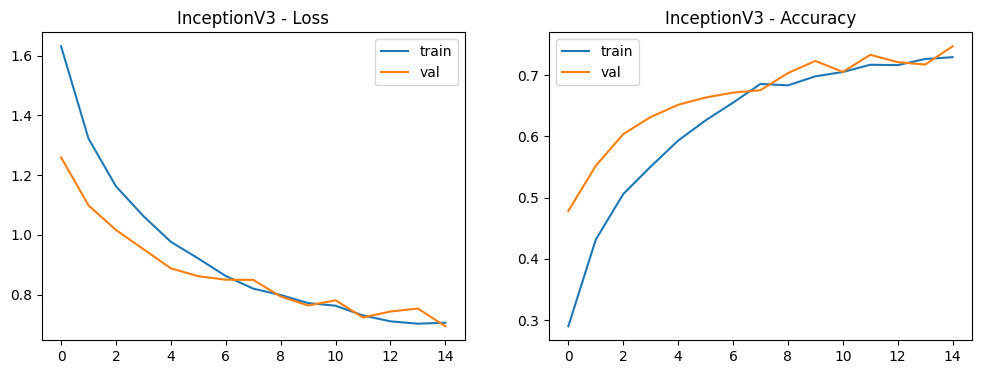

In [8]:
# 5️) MODEL TRAINING

print("✅ Training models...")
results = []

def train_model(model, name):
    print(f"\nTraining {name} ...")
    cb = [
        callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        callbacks.ModelCheckpoint(f"{OUTPUT_DIR}/{name}_best.h5", save_best_only=True)
    ]
    model.compile(optimizer=optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=cb)
    # Plot history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f'{name} - Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f'{name} - Accuracy'); plt.legend()
    plt.show()
    return model, history

# Train Custom CNN
custom_cnn, history_cnn = train_model(custom_cnn, "CustomCNN")

# Train Transfer Models
for name, model in transfer_models.items():
    model, hist = train_model(model, name)
    transfer_models[name] = model

✅ Evaluating models...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


📊 CustomCNN Results:
Accuracy=0.3252  Precision=0.1058  Recall=0.3252  F1=0.1596
              precision    recall  f1-score   support

      glioma       0.33      1.00      0.49        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.33       246
   macro avg       0.08      0.25      0.12       246
weighted avg       0.11      0.33      0.16       246



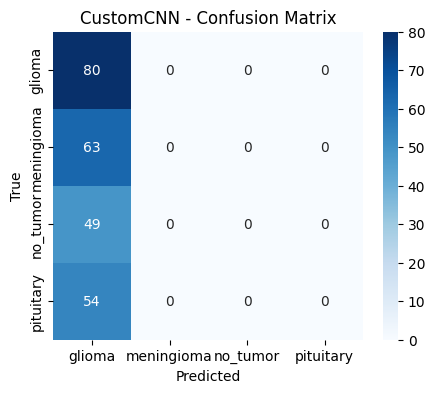

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


📊 ResNet50 Results:
Accuracy=0.4228  Precision=0.5282  Recall=0.4228  F1=0.3045
              precision    recall  f1-score   support

      glioma       0.37      1.00      0.54        80
  meningioma       1.00      0.03      0.06        63
    no_tumor       0.76      0.45      0.56        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.42       246
   macro avg       0.53      0.37      0.29       246
weighted avg       0.53      0.42      0.30       246



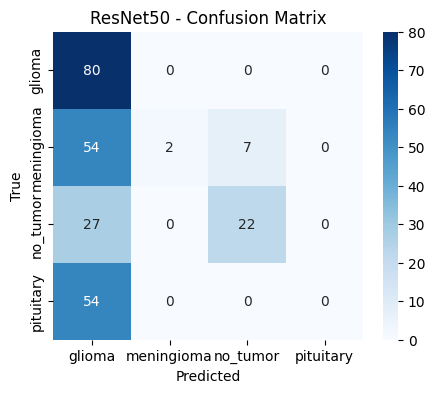


📊 MobileNetV2 Results:
Accuracy=0.7114  Precision=0.7534  Recall=0.7114  F1=0.7169
              precision    recall  f1-score   support

      glioma       0.88      0.71      0.79        80
  meningioma       0.62      0.56      0.59        63
    no_tumor       0.95      0.71      0.81        49
   pituitary       0.55      0.89      0.68        54

    accuracy                           0.71       246
   macro avg       0.75      0.72      0.72       246
weighted avg       0.75      0.71      0.72       246



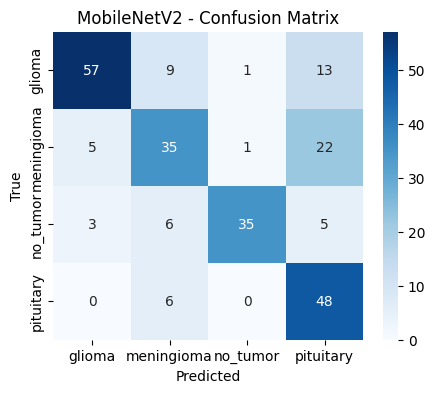


📊 InceptionV3 Results:
Accuracy=0.6992  Precision=0.7107  Recall=0.6992  F1=0.6834
              precision    recall  f1-score   support

      glioma       0.80      0.80      0.80        80
  meningioma       0.60      0.33      0.43        63
    no_tumor       0.85      0.71      0.78        49
   pituitary       0.58      0.96      0.72        54

    accuracy                           0.70       246
   macro avg       0.71      0.70      0.68       246
weighted avg       0.71      0.70      0.68       246



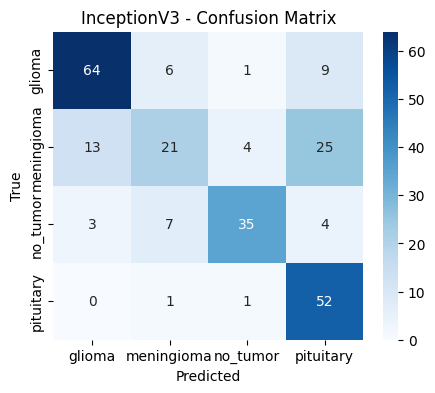

In [9]:
# 6️) MODEL EVALUATION

print("✅ Evaluating models...")

def evaluate_model(model, name):
    y_true, y_pred = [], []
    for imgs, labels in test_ds:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f"\n📊 {name} Results:")
    print(f"Accuracy={acc:.4f}  Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()
    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# Evaluate all models
results.append(evaluate_model(custom_cnn, "CustomCNN"))
for name, model in transfer_models.items():
    results.append(evaluate_model(model, name))


✅ Model Comparison Summary:
         model  accuracy  precision    recall        f1
2  MobileNetV2  0.711382   0.753393  0.711382  0.716854
3  InceptionV3  0.699187   0.710688  0.699187  0.683379
1     ResNet50  0.422764   0.528211  0.422764  0.304503
0    CustomCNN  0.325203   0.105757  0.325203  0.159609


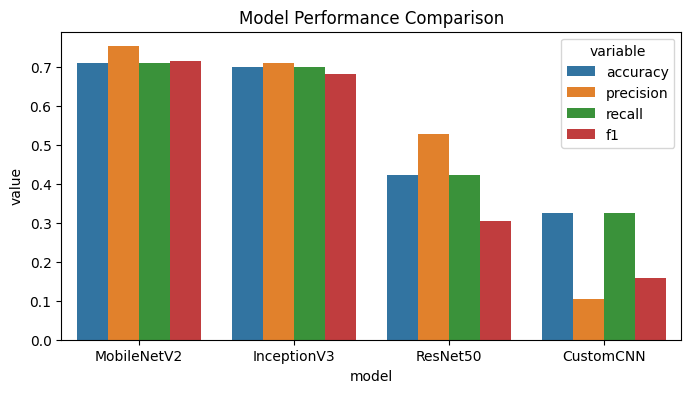


🏆 Best Performing Model: MobileNetV2


In [10]:
# 7️) MODEL COMPARISON

df = pd.DataFrame(results).sort_values("f1", ascending=False)
print("\n✅ Model Comparison Summary:")
print(df)

plt.figure(figsize=(8,4))
sns.barplot(data=df.melt(id_vars='model', value_vars=['accuracy','precision','recall','f1']),
            x='model', y='value', hue='variable')
plt.title("Model Performance Comparison")
plt.show()

best_model_name = df.iloc[0]["model"]
print(f"\n🏆 Best Performing Model: {best_model_name}")

In [11]:
import pickle
from tensorflow.keras.models import load_model

# save to h5
best_model_path = f"models_outputs/{best_model_name}_best.h5"
best_model = load_model(best_model_path)

# Save to pickle
pickle_path = f"models_outputs/{best_model_name}_best.pkl"
with open(pickle_path, "wb") as f:
    pickle.dump(best_model, f)

print(f"✅ Saved best model as: {pickle_path}")

✅ Saved best model as: models_outputs/MobileNetV2_best.pkl
